In [ ]:
import numpy as np
import pygame

# --- ENVIRONNEMENT ---
class DenseRewardMaze:
    def __init__(self, size=15, reward_density=0.05):
        self.size = size
        self.number_states = size * size
        self.number_actions = 5  # UP, DOWN, LEFT, RIGHT, EXPLOIT
        self.states = np.arange(self.number_states)
        self.actions = np.arange(self.number_actions)
        self.reward_density = reward_density
        self.init_transitions()
        self.agent1_meals = 0
        self.agent2_meals = 0
        self.new_episode()

    def init_transitions(self):
        self.P = np.zeros((self.number_states, self.number_actions, self.number_states))
        for s in self.states:
            row, col = divmod(s, self.size)
            self.P[s, 0, s if row == 0 else s - self.size] = 1
            self.P[s, 1, s if row == self.size - 1 else s + self.size] = 1
            self.P[s, 2, s if col == 0 else s - 1] = 1
            self.P[s, 3, s if col == self.size - 1 else s + 1] = 1
            self.P[s, 4, s] = 1  # EXPLOIT

    def generate_rewards(self):
        self.rewards = np.zeros(self.number_states)
        num_rewards = int(self.reward_density * self.number_states)
        possible = [s for s in self.states if s not in (self.agent1_state, self.agent2_state)]
        reward_positions = np.random.choice(possible, size=num_rewards, replace=False)
        for pos in reward_positions:
            self.rewards[pos] = 1

    def make_step(self, agent_index, action):
        state = self.agent1_state if agent_index == 1 else self.agent2_state
        probs = self.P[state, action]
        new_state = np.random.choice(self.states, p=probs)

        if agent_index == 1:
            self.agent1_state = new_state
        else:
            self.agent2_state = new_state

        reward = self.rewards[new_state]
        if reward > 0:
            if agent_index == 1:
                self.agent1_meals += 1
            else:
                self.agent2_meals += 1
            self.rewards[new_state] = 0  # consomme
        return reward, new_state

    def new_episode(self):
        self.agent1_state = 0
        self.agent2_state = self.number_states - 1
        self.agent1_meals = 0
        self.agent2_meals = 0
        self.generate_rewards()


# --- AGENT EMPATHIQUE ---
class EmpathicAgent:
    def __init__(self, env, agent_id):
        self.env = env
        self.agent_id = agent_id
        self.size = env.size

    def state_to_xy(self, state):
        return divmod(state, self.size)

    def choose_action(self, current_state):
        own = self.env.agent1_meals if self.agent_id == 1 else self.env.agent2_meals
        other = self.env.agent2_meals if self.agent_id == 1 else self.env.agent1_meals

        if own > other:
            return np.random.choice(self.env.actions)

        # Aller vers la case avec reward la plus proche
        r1, c1 = self.state_to_xy(current_state)
        min_dist = float('inf')
        target = None
        for s, v in enumerate(self.env.rewards):
            if v > 0:
                r2, c2 = self.state_to_xy(s)
                dist = abs(r1 - r2) + abs(c1 - c2)
                if dist < min_dist:
                    min_dist = dist
                    target = (r2, c2)

        if target:
            r2, c2 = target
            if r1 < r2: return 1
            elif r1 > r2: return 0
            elif c1 < c2: return 3
            elif c1 > c2: return 2
            else: return 4

        return np.random.choice(self.env.actions)


# --- AFFICHAGE ---
class MazeViewer:
    def __init__(self, env, tile_size=40):
        pygame.init()
        self.env = env
        self.size = env.size
        self.tile_size = tile_size
        self.screen = pygame.display.set_mode((self.size * tile_size, self.size * tile_size + 40))
        self.font = pygame.font.SysFont("Arial", 20)
        pygame.display.set_caption("15x15 Maze - Empathic Agents + Dense Rewards")

    def render(self):
        self.screen.fill((220, 220, 220))
        for s in self.env.states:
            x, y = divmod(s, self.size)
            rect = pygame.Rect(y * self.tile_size, x * self.tile_size, self.tile_size, self.tile_size)

            if self.env.rewards[s] > 0:
                color = (255, 215, 0)
            else:
                color = (255, 255, 255)

            pygame.draw.rect(self.screen, color, rect)
            pygame.draw.rect(self.screen, (0, 0, 0), rect, 1)

        # agent 1 (bleu)
        x1, y1 = divmod(self.env.agent1_state, self.size)
        rect1 = pygame.Rect(y1 * self.tile_size + 5, x1 * self.tile_size + 5,
                            self.tile_size - 10, self.tile_size - 10)
        pygame.draw.rect(self.screen, (0, 100, 255), rect1)

        # agent 2 (rouge)
        x2, y2 = divmod(self.env.agent2_state, self.size)
        rect2 = pygame.Rect(y2 * self.tile_size + 5, x2 * self.tile_size + 5,
                            self.tile_size - 10, self.tile_size - 10)
        pygame.draw.rect(self.screen, (255, 50, 50), rect2)

        # texte compteur
        info = f"Repas A1: {self.env.agent1_meals} | A2: {self.env.agent2_meals}"
        text_surface = self.font.render(info, True, (0, 0, 0))
        self.screen.blit(text_surface, (10, self.size * self.tile_size + 5))

        pygame.display.flip()

        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                exit()


# --- LANCEMENT ---
def run_demo():
    env = DenseRewardMaze(size=15, reward_density=0.07)
    a1 = EmpathicAgent(env, agent_id=1)
    a2 = EmpathicAgent(env, agent_id=2)
    viewer = MazeViewer(env)

    episodes = 5
    steps = 50

    for _ in range(episodes):
        env.new_episode()
        for _ in range(steps):
            viewer.render()
            env.make_step(1, a1.choose_action(env.agent1_state))
            env.make_step(2, a2.choose_action(env.agent2_state))
            pygame.time.wait(100)

    viewer.render()
    pygame.time.wait(1000)
    viewer.close()


if __name__ == "__main__":
    run_demo()


pygame 2.5.2 (SDL 2.28.3, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


error: display Surface quit

: 

In [ ]:
import numpy as np
import pygame

# --- ENVIRONNEMENT ---
class DenseRewardMaze:
    def __init__(self, size=15, reward_density=0.07):
        self.size = size
        self.number_states = size * size
        self.number_actions = 5
        self.states = np.arange(self.number_states)
        self.actions = np.arange(self.number_actions)
        self.reward_density = reward_density
        self.init_transitions()
        self.agent1_meals = 0
        self.agent2_meals = 0
        self.new_episode()

    def init_transitions(self):
        self.P = np.zeros((self.number_states, self.number_actions, self.number_states))
        for s in self.states:
            row, col = divmod(s, self.size)
            self.P[s, 0, s if row == 0 else s - self.size] = 1
            self.P[s, 1, s if row == self.size - 1 else s + self.size] = 1
            self.P[s, 2, s if col == 0 else s - 1] = 1
            self.P[s, 3, s if col == self.size - 1 else s + 1] = 1
            self.P[s, 4, s] = 1

    def generate_rewards(self):
        self.rewards = np.zeros(self.number_states)
        num_rewards = int(self.reward_density * self.number_states)
        forbidden = [self.agent1_state, self.agent2_state]
        possible = [s for s in self.states if s not in forbidden]
        reward_positions = np.random.choice(possible, size=num_rewards, replace=False)
        for pos in reward_positions:
            self.rewards[pos] = 1

    def make_step(self, agent_index, action):
        state = self.agent1_state if agent_index == 1 else self.agent2_state
        probs = self.P[state, action]
        new_state = np.random.choice(self.states, p=probs)

        if agent_index == 1:
            self.agent1_state = new_state
        else:
            self.agent2_state = new_state

        reward = self.rewards[new_state]
        if reward > 0:
            if agent_index == 1:
                self.agent1_meals += 1
            else:
                self.agent2_meals += 1
            self.rewards[new_state] = 0
        return reward, new_state

    def new_episode(self):
        self.agent1_state = 0
        self.agent2_state = self.number_states - 1
        self.agent1_meals = 0
        self.agent2_meals = 0
        self.generate_rewards()


# --- AGENT configurable avec empathie ---
class ConfigurableAgent:
    def __init__(self, env, agent_id, empathy=True):
        self.env = env
        self.agent_id = agent_id
        self.empathy = empathy
        self.size = env.size

    def state_to_xy(self, state):
        return divmod(state, self.size)

    def choose_action(self, current_state):
        own = self.env.agent1_meals if self.agent_id == 1 else self.env.agent2_meals
        other = self.env.agent2_meals if self.agent_id == 1 else self.env.agent1_meals

        if self.empathy and own > other:
            return np.random.choice(self.env.actions)

        # Aller vers la récompense la plus proche
        r1, c1 = self.state_to_xy(current_state)
        min_dist = float('inf')
        target = None
        for s, v in enumerate(self.env.rewards):
            if v > 0:
                r2, c2 = self.state_to_xy(s)
                dist = abs(r1 - r2) + abs(c1 - c2)
                if dist < min_dist:
                    min_dist = dist
                    target = (r2, c2)

        if target:
            r2, c2 = target
            if r1 < r2: return 1
            elif r1 > r2: return 0
            elif c1 < c2: return 3
            elif c1 > c2: return 2
            else: return 4

        return np.random.choice(self.env.actions)


# --- AFFICHAGE ---
class MazeViewer:
    def __init__(self, env, tile_size=40):
        pygame.init()
        self.env = env
        self.size = env.size
        self.tile_size = tile_size
        self.screen = pygame.display.set_mode((self.size * tile_size, self.size * tile_size + 40))
        self.font = pygame.font.SysFont("Arial", 20)
        pygame.display.set_caption("Maze with Empathy Configurable Agents")

    def render(self):
        self.screen.fill((220, 220, 220))
        for s in self.env.states:
            x, y = divmod(s, self.size)
            rect = pygame.Rect(y * self.tile_size, x * self.tile_size, self.tile_size, self.tile_size)

            if self.env.rewards[s] > 0:
                color = (255, 215, 0)
            else:
                color = (255, 255, 255)

            pygame.draw.rect(self.screen, color, rect)
            pygame.draw.rect(self.screen, (0, 0, 0), rect, 1)

        # Agent 1 (bleu)
        x1, y1 = divmod(self.env.agent1_state, self.size)
        r1 = pygame.Rect(y1 * self.tile_size + 5, x1 * self.tile_size + 5,
                         self.tile_size - 10, self.tile_size - 10)
        pygame.draw.rect(self.screen, (0, 100, 255), r1)

        # Agent 2 (rouge)
        x2, y2 = divmod(self.env.agent2_state, self.size)
        r2 = pygame.Rect(y2 * self.tile_size + 5, x2 * self.tile_size + 5,
                         self.tile_size - 10, self.tile_size - 10)
        pygame.draw.rect(self.screen, (255, 50, 50), r2)

        # Compteur
        info = f"A1 (bleu): {self.env.agent1_meals}  |  A2 (rouge): {self.env.agent2_meals}"
        txt = self.font.render(info, True, (0, 0, 0))
        self.screen.blit(txt, (10, self.size * self.tile_size + 5))
        pygame.display.flip()

        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                exit()


# --- LANCEMENT ---
def run_demo():
    env = DenseRewardMaze(size=15, reward_density=0.06)
    agent1 = ConfigurableAgent(env, agent_id=1, empathy=False)
    agent2 = ConfigurableAgent(env, agent_id=2, empathy=False)
    viewer = MazeViewer(env)

    episodes = 5
    steps = 50

    for _ in range(episodes):
        env.new_episode()
        for _ in range(steps):
            viewer.render()
            env.make_step(1, agent1.choose_action(env.agent1_state))
            env.make_step(2, agent2.choose_action(env.agent2_state))
            pygame.time.wait(100)

    viewer.render()
    pygame.time.wait(1000)
    viewer.close()


if __name__ == "__main__":
    run_demo()


pygame 2.5.2 (SDL 2.28.3, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


error: display Surface quit

: 

In [ ]:
import numpy as np
import pygame

# --- PARAMÈTRE GLOBAL D'EMPATHIE ---
global_empathy = True  # Change à False pour désactiver l'empathie pour tous les agents

# --- ENVIRONNEMENT ---
class DenseRewardMaze:
    def __init__(self, size=15, reward_density=0.07):
        self.size = size
        self.number_states = size * size
        self.number_actions = 5
        self.states = np.arange(self.number_states)
        self.actions = np.arange(self.number_actions)
        self.reward_density = reward_density
        self.init_transitions()
        self.agent1_meals = 0
        self.agent2_meals = 0
        self.new_episode()

    def init_transitions(self):
        self.P = np.zeros((self.number_states, self.number_actions, self.number_states))
        for s in self.states:
            row, col = divmod(s, self.size)
            self.P[s, 0, s if row == 0 else s - self.size] = 1
            self.P[s, 1, s if row == self.size - 1 else s + self.size] = 1
            self.P[s, 2, s if col == 0 else s - 1] = 1
            self.P[s, 3, s if col == self.size - 1 else s + 1] = 1
            self.P[s, 4, s] = 1

    def generate_rewards(self):
        self.rewards = np.zeros(self.number_states)
        num_rewards = int(self.reward_density * self.number_states)
        forbidden = [self.agent1_state, self.agent2_state]
        possible = [s for s in self.states if s not in forbidden]
        reward_positions = np.random.choice(possible, size=num_rewards, replace=False)
        for pos in reward_positions:
            self.rewards[pos] = 1

    def make_step(self, agent_index, action):
        state = self.agent1_state if agent_index == 1 else self.agent2_state
        probs = self.P[state, action]
        new_state = np.random.choice(self.states, p=probs)

        if agent_index == 1:
            self.agent1_state = new_state
        else:
            self.agent2_state = new_state

        reward = self.rewards[new_state]
        if reward > 0:
            if agent_index == 1:
                self.agent1_meals += 1
            else:
                self.agent2_meals += 1
            self.rewards[new_state] = 0
        return reward, new_state

    def new_episode(self):
        self.agent1_state = 0
        self.agent2_state = self.number_states - 1
        self.agent1_meals = 0
        self.agent2_meals = 0
        self.generate_rewards()


# --- AGENT CONFIGURABLE AVEC EMPATHIE GLOBALE ---
class ConfigurableAgent:
    def __init__(self, env, agent_id):
        self.env = env
        self.agent_id = agent_id
        self.size = env.size

    def state_to_xy(self, state):
        return divmod(state, self.size)

    def choose_action(self, current_state):
        own = self.env.agent1_meals if self.agent_id == 1 else self.env.agent2_meals
        other = self.env.agent2_meals if self.agent_id == 1 else self.env.agent1_meals

        if global_empathy and own > other:
            return np.random.choice(self.env.actions)

        r1, c1 = self.state_to_xy(current_state)
        min_dist = float('inf')
        target = None
        for s, v in enumerate(self.env.rewards):
            if v > 0:
                r2, c2 = self.state_to_xy(s)
                dist = abs(r1 - r2) + abs(c1 - c2)
                if dist < min_dist:
                    min_dist = dist
                    target = (r2, c2)

        if target:
            r2, c2 = target
            if r1 < r2: return 1
            elif r1 > r2: return 0
            elif c1 < c2: return 3
            elif c1 > c2: return 2
            else: return 4

        return np.random.choice(self.env.actions)


# --- AFFICHAGE ---
class MazeViewer:
    def __init__(self, env, tile_size=40):
        pygame.init()
        self.env = env
        self.size = env.size
        self.tile_size = tile_size
        self.screen = pygame.display.set_mode((self.size * tile_size, self.size * tile_size + 40))
        self.font = pygame.font.SysFont("Arial", 20)
        pygame.display.set_caption("Maze - Empathie Globale")

    def render(self):
        self.screen.fill((220, 220, 220))
        for s in self.env.states:
            x, y = divmod(s, self.size)
            rect = pygame.Rect(y * self.tile_size, x * self.tile_size, self.tile_size, self.tile_size)

            if self.env.rewards[s] > 0:
                color = (255, 215, 0)
            else:
                color = (255, 255, 255)

            pygame.draw.rect(self.screen, color, rect)
            pygame.draw.rect(self.screen, (0, 0, 0), rect, 1)

        # Agent 1
        x1, y1 = divmod(self.env.agent1_state, self.size)
        r1 = pygame.Rect(y1 * self.tile_size + 5, x1 * self.tile_size + 5,
                         self.tile_size - 10, self.tile_size - 10)
        pygame.draw.rect(self.screen, (0, 100, 255), r1)

        # Agent 2
        x2, y2 = divmod(self.env.agent2_state, self.size)
        r2 = pygame.Rect(y2 * self.tile_size + 5, x2 * self.tile_size + 5,
                         self.tile_size - 10, self.tile_size - 10)
        pygame.draw.rect(self.screen, (255, 50, 50), r2)

        # Texte
        info = f"A1: {self.env.agent1_meals} repas | A2: {self.env.agent2_meals} repas"
        text_surface = self.font.render(info, True, (0, 0, 0))
        self.screen.blit(text_surface, (10, self.size * self.tile_size + 5))
        pygame.display.flip()

        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                exit()


# --- SIMULATION ---
def run_demo():
    env = DenseRewardMaze(size=15, reward_density=0.06)
    agent1 = ConfigurableAgent(env, agent_id=1)
    agent2 = ConfigurableAgent(env, agent_id=2)
    viewer = MazeViewer(env)

    episodes = 5
    steps = 50

    for _ in range(episodes):
        env.new_episode()
        for _ in range(steps):
            viewer.render()
            env.make_step(1, agent1.choose_action(env.agent1_state))
            env.make_step(2, agent2.choose_action(env.agent2_state))
            pygame.time.wait(100)

    viewer.render()
    pygame.time.wait(1000)
    viewer.close()


if __name__ == "__main__":
    run_demo()


pygame 2.5.2 (SDL 2.28.3, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


error: display Surface quit

: 

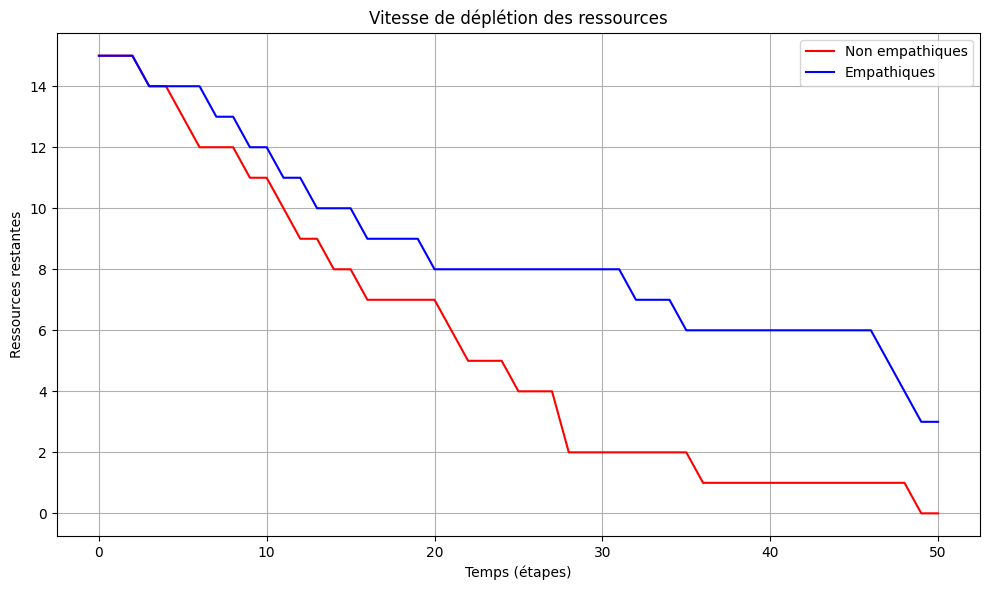

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- PARAMÈTRE GLOBAL (modifié à la volée) ---
global_empathy = True  # sera changé entre les runs

# --- ENVIRONNEMENT ---
class DenseRewardMaze:
    def __init__(self, size=15, reward_density=0.07):
        self.size = size
        self.number_states = size * size
        self.number_actions = 5
        self.states = np.arange(self.number_states)
        self.actions = np.arange(self.number_actions)
        self.reward_density = reward_density
        self.init_transitions()
        self.agent1_meals = 0
        self.agent2_meals = 0
        self.new_episode()

    def init_transitions(self):
        self.P = np.zeros((self.number_states, self.number_actions, self.number_states))
        for s in self.states:
            row, col = divmod(s, self.size)
            self.P[s, 0, s if row == 0 else s - self.size] = 1
            self.P[s, 1, s if row == self.size - 1 else s + self.size] = 1
            self.P[s, 2, s if col == 0 else s - 1] = 1
            self.P[s, 3, s if col == self.size - 1 else s + 1] = 1
            self.P[s, 4, s] = 1

    def generate_rewards(self):
        self.rewards = np.zeros(self.number_states)
        num_rewards = int(self.reward_density * self.number_states)
        forbidden = [self.agent1_state, self.agent2_state]
        possible = [s for s in self.states if s not in forbidden]
        reward_positions = np.random.choice(possible, size=num_rewards, replace=False)
        for pos in reward_positions:
            self.rewards[pos] = 1

    def make_step(self, agent_index, action):
        state = self.agent1_state if agent_index == 1 else self.agent2_state
        probs = self.P[state, action]
        new_state = np.random.choice(self.states, p=probs)

        if agent_index == 1:
            self.agent1_state = new_state
        else:
            self.agent2_state = new_state

        reward = self.rewards[new_state]
        if reward > 0:
            if agent_index == 1:
                self.agent1_meals += 1
            else:
                self.agent2_meals += 1
            self.rewards[new_state] = 0
        return reward, new_state

    def new_episode(self):
        self.agent1_state = 0
        self.agent2_state = self.number_states - 1
        self.agent1_meals = 0
        self.agent2_meals = 0
        self.generate_rewards()

    def remaining_resources(self):
        return int(np.sum(self.rewards))


# --- AGENT CONFIGURABLE PAR EMPATHIE GLOBALE ---
class ConfigurableAgent:
    def __init__(self, env, agent_id):
        self.env = env
        self.agent_id = agent_id
        self.size = env.size

    def state_to_xy(self, state):
        return divmod(state, self.size)

    def choose_action(self, current_state):
        own = self.env.agent1_meals if self.agent_id == 1 else self.env.agent2_meals
        other = self.env.agent2_meals if self.agent_id == 1 else self.env.agent1_meals

        if global_empathy and own > other:
            return np.random.choice(self.env.actions)

        r1, c1 = self.state_to_xy(current_state)
        min_dist = float('inf')
        target = None
        for s, v in enumerate(self.env.rewards):
            if v > 0:
                r2, c2 = self.state_to_xy(s)
                dist = abs(r1 - r2) + abs(c1 - c2)
                if dist < min_dist:
                    min_dist = dist
                    target = (r2, c2)

        if target:
            r2, c2 = target
            if r1 < r2: return 1
            elif r1 > r2: return 0
            elif c1 < c2: return 3
            elif c1 > c2: return 2
            else: return 4

        return np.random.choice(self.env.actions)


# --- EXPÉRIENCE COMPARATIVE ---
def run_simulation(empathy_setting, steps=50, size=15, density=0.07):
    global global_empathy
    global_empathy = empathy_setting

    env = DenseRewardMaze(size=size, reward_density=density)
    agent1 = ConfigurableAgent(env, agent_id=1)
    agent2 = ConfigurableAgent(env, agent_id=2)

    env.new_episode()
    resources_over_time = [env.remaining_resources()]

    for _ in range(steps):
        env.make_step(1, agent1.choose_action(env.agent1_state))
        env.make_step(2, agent2.choose_action(env.agent2_state))
        resources_over_time.append(env.remaining_resources())

    return resources_over_time


# --- AFFICHAGE GRAPHIQUE ---
def plot_resource_depletion():
    steps = 50
    non_empathic = run_simulation(empathy_setting=False, steps=steps)
    empathic = run_simulation(empathy_setting=True, steps=steps)

    plt.figure(figsize=(10, 6))
    plt.plot(non_empathic, label="Non empathiques", color='red')
    plt.plot(empathic, label="Empathiques", color='blue')
    plt.xlabel("Temps (étapes)")
    plt.ylabel("Ressources restantes")
    plt.title("Vitesse de déplétion des ressources")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    plot_resource_depletion()


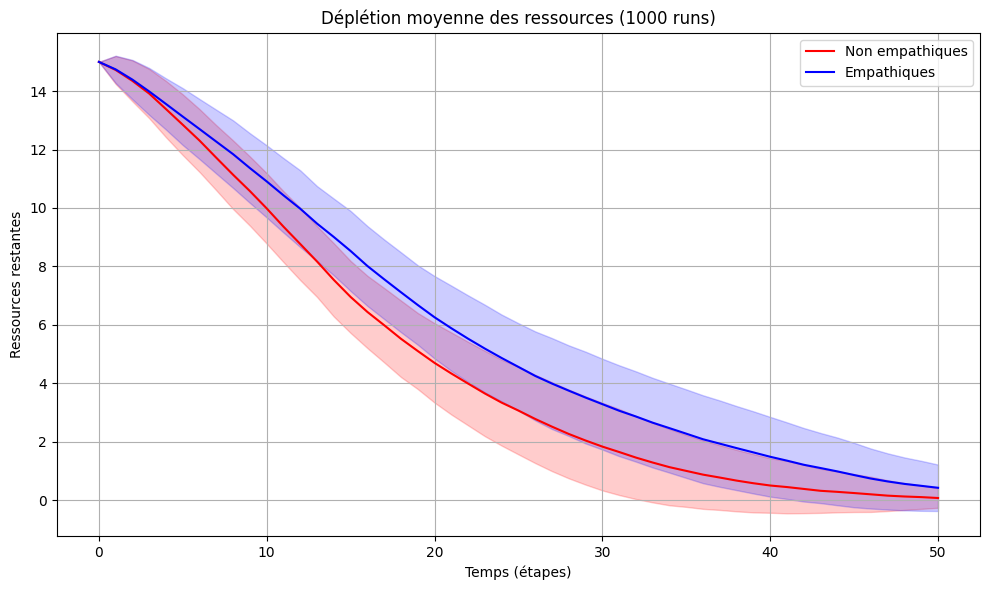

In [6]:
import numpy as np
import matplotlib.pyplot as plt

global_empathy = True  # ce paramètre est modifié dynamiquement

# --- ENVIRONNEMENT ---
class DenseRewardMaze:
    def __init__(self, size=15, reward_density=0.07):
        self.size = size
        self.number_states = size * size
        self.number_actions = 5
        self.states = np.arange(self.number_states)
        self.actions = np.arange(self.number_actions)
        self.reward_density = reward_density
        self.init_transitions()
        self.agent1_meals = 0
        self.agent2_meals = 0
        self.new_episode()

    def init_transitions(self):
        self.P = np.zeros((self.number_states, self.number_actions, self.number_states))
        for s in self.states:
            row, col = divmod(s, self.size)
            self.P[s, 0, s if row == 0 else s - self.size] = 1
            self.P[s, 1, s if row == self.size - 1 else s + self.size] = 1
            self.P[s, 2, s if col == 0 else s - 1] = 1
            self.P[s, 3, s if col == self.size - 1 else s + 1] = 1
            self.P[s, 4, s] = 1

    def generate_rewards(self):
        self.rewards = np.zeros(self.number_states)
        num_rewards = int(self.reward_density * self.number_states)
        forbidden = [self.agent1_state, self.agent2_state]
        possible = [s for s in self.states if s not in forbidden]
        reward_positions = np.random.choice(possible, size=num_rewards, replace=False)
        for pos in reward_positions:
            self.rewards[pos] = 1

    def make_step(self, agent_index, action):
        state = self.agent1_state if agent_index == 1 else self.agent2_state
        probs = self.P[state, action]
        new_state = np.random.choice(self.states, p=probs)

        if agent_index == 1:
            self.agent1_state = new_state
        else:
            self.agent2_state = new_state

        reward = self.rewards[new_state]
        if reward > 0:
            if agent_index == 1:
                self.agent1_meals += 1
            else:
                self.agent2_meals += 1
            self.rewards[new_state] = 0
        return reward, new_state

    def new_episode(self):
        self.agent1_state = 0
        self.agent2_state = self.number_states - 1
        self.agent1_meals = 0
        self.agent2_meals = 0
        self.generate_rewards()

    def remaining_resources(self):
        return int(np.sum(self.rewards))


# --- AGENT AVEC EMPATHIE GLOBALE ---
class ConfigurableAgent:
    def __init__(self, env, agent_id):
        self.env = env
        self.agent_id = agent_id
        self.size = env.size

    def state_to_xy(self, state):
        return divmod(state, self.size)

    def choose_action(self, current_state):
        own = self.env.agent1_meals if self.agent_id == 1 else self.env.agent2_meals
        other = self.env.agent2_meals if self.agent_id == 1 else self.env.agent1_meals

        if global_empathy and own > other:
            return np.random.choice(self.env.actions)

        r1, c1 = self.state_to_xy(current_state)
        min_dist = float('inf')
        target = None
        for s, v in enumerate(self.env.rewards):
            if v > 0:
                r2, c2 = self.state_to_xy(s)
                dist = abs(r1 - r2) + abs(c1 - c2)
                if dist < min_dist:
                    min_dist = dist
                    target = (r2, c2)

        if target:
            r2, c2 = target
            if r1 < r2: return 1
            elif r1 > r2: return 0
            elif c1 < c2: return 3
            elif c1 > c2: return 2
            else: return 4

        return np.random.choice(self.env.actions)


# --- SIMULATION UNIQUE ---
def run_simulation(empathy_setting, steps=50, size=15, density=0.07):
    global global_empathy
    global_empathy = empathy_setting

    env = DenseRewardMaze(size=size, reward_density=density)
    agent1 = ConfigurableAgent(env, agent_id=1)
    agent2 = ConfigurableAgent(env, agent_id=2)

    env.new_episode()
    resources_over_time = [env.remaining_resources()]

    for _ in range(steps):
        env.make_step(1, agent1.choose_action(env.agent1_state))
        env.make_step(2, agent2.choose_action(env.agent2_state))
        resources_over_time.append(env.remaining_resources())

    return np.array(resources_over_time)


# --- MOYENNE SUR PLUSIEURS TESTS ---
def averaged_simulations(nb_runs=10, steps=50, empathy=True):
    all_runs = [run_simulation(empathy_setting=empathy, steps=steps) for _ in range(nb_runs)]
    return np.mean(all_runs, axis=0), np.std(all_runs, axis=0)


# --- AFFICHAGE ---
def plot_resource_depletion_avg():
    steps = 50
    runs = 1000

    mean_non_em, std_non_em = averaged_simulations(nb_runs=runs, steps=steps, empathy=False)
    mean_em, std_em = averaged_simulations(nb_runs=runs, steps=steps, empathy=True)

    x = np.arange(steps + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(x, mean_non_em, label="Non empathiques", color='red')
    plt.fill_between(x, mean_non_em - std_non_em, mean_non_em + std_non_em, alpha=0.2, color='red')

    plt.plot(x, mean_em, label="Empathiques", color='blue')
    plt.fill_between(x, mean_em - std_em, mean_em + std_em, alpha=0.2, color='blue')

    plt.xlabel("Temps (étapes)")
    plt.ylabel("Ressources restantes")
    plt.title(f"Déplétion moyenne des ressources ({runs} runs)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    plot_resource_depletion_avg()


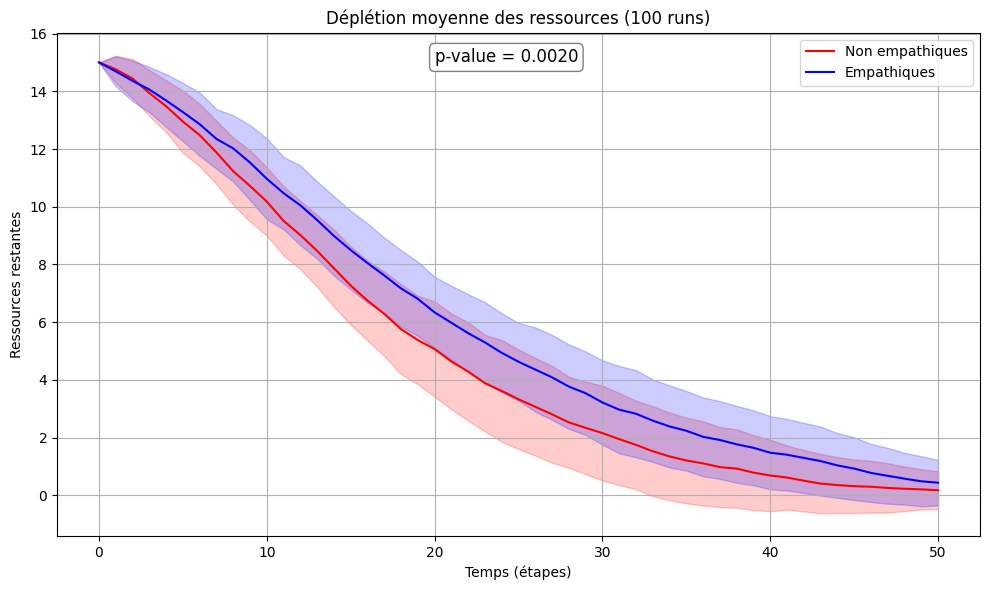

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

global_empathy = True  # utilisé par les agents, changé dynamiquement

# --- ENVIRONNEMENT ---
class DenseRewardMaze:
    def __init__(self, size=15, reward_density=0.07):
        self.size = size
        self.number_states = size * size
        self.number_actions = 5
        self.states = np.arange(self.number_states)
        self.actions = np.arange(self.number_actions)
        self.reward_density = reward_density
        self.init_transitions()
        self.agent1_meals = 0
        self.agent2_meals = 0
        self.new_episode()

    def init_transitions(self):
        self.P = np.zeros((self.number_states, self.number_actions, self.number_states))
        for s in self.states:
            row, col = divmod(s, self.size)
            self.P[s, 0, s if row == 0 else s - self.size] = 1
            self.P[s, 1, s if row == self.size - 1 else s + self.size] = 1
            self.P[s, 2, s if col == 0 else s - 1] = 1
            self.P[s, 3, s if col == self.size - 1 else s + 1] = 1
            self.P[s, 4, s] = 1

    def generate_rewards(self):
        self.rewards = np.zeros(self.number_states)
        num_rewards = int(self.reward_density * self.number_states)
        forbidden = [self.agent1_state, self.agent2_state]
        possible = [s for s in self.states if s not in forbidden]
        reward_positions = np.random.choice(possible, size=num_rewards, replace=False)
        for pos in reward_positions:
            self.rewards[pos] = 1

    def make_step(self, agent_index, action):
        state = self.agent1_state if agent_index == 1 else self.agent2_state
        probs = self.P[state, action]
        new_state = np.random.choice(self.states, p=probs)

        if agent_index == 1:
            self.agent1_state = new_state
        else:
            self.agent2_state = new_state

        reward = self.rewards[new_state]
        if reward > 0:
            if agent_index == 1:
                self.agent1_meals += 1
            else:
                self.agent2_meals += 1
            self.rewards[new_state] = 0
        return reward, new_state

    def new_episode(self):
        self.agent1_state = 0
        self.agent2_state = self.number_states - 1
        self.agent1_meals = 0
        self.agent2_meals = 0
        self.generate_rewards()

    def remaining_resources(self):
        return int(np.sum(self.rewards))


# --- AGENT AVEC EMPATHIE GLOBALE ---
class ConfigurableAgent:
    def __init__(self, env, agent_id):
        self.env = env
        self.agent_id = agent_id
        self.size = env.size

    def state_to_xy(self, state):
        return divmod(state, self.size)

    def choose_action(self, current_state):
        own = self.env.agent1_meals if self.agent_id == 1 else self.env.agent2_meals
        other = self.env.agent2_meals if self.agent_id == 1 else self.env.agent1_meals

        if global_empathy and own > other:
            return np.random.choice(self.env.actions)

        r1, c1 = self.state_to_xy(current_state)
        min_dist = float('inf')
        target = None
        for s, v in enumerate(self.env.rewards):
            if v > 0:
                r2, c2 = self.state_to_xy(s)
                dist = abs(r1 - r2) + abs(c1 - c2)
                if dist < min_dist:
                    min_dist = dist
                    target = (r2, c2)

        if target:
            r2, c2 = target
            if r1 < r2: return 1
            elif r1 > r2: return 0
            elif c1 < c2: return 3
            elif c1 > c2: return 2
            else: return 4

        return np.random.choice(self.env.actions)


# --- SIMULATION UNIQUE ---
def run_simulation(empathy_setting, steps=50, size=15, density=0.07):
    global global_empathy
    global_empathy = empathy_setting

    env = DenseRewardMaze(size=size, reward_density=density)
    agent1 = ConfigurableAgent(env, agent_id=1)
    agent2 = ConfigurableAgent(env, agent_id=2)

    env.new_episode()
    resources_over_time = [env.remaining_resources()]

    for _ in range(steps):
        env.make_step(1, agent1.choose_action(env.agent1_state))
        env.make_step(2, agent2.choose_action(env.agent2_state))
        resources_over_time.append(env.remaining_resources())

    return np.array(resources_over_time)


# --- MOYENNE SUR PLUSIEURS TESTS ---
def multiple_runs_data(nb_runs=500, steps=50, empathy=True):
    return [run_simulation(empathy_setting=empathy, steps=steps) for _ in range(nb_runs)]


# --- AFFICHAGE AVEC TEST STATISTIQUE ---
def plot_resource_depletion_avg(nb_runs=100, steps=50):
    non_em_runs = multiple_runs_data(nb_runs, steps, empathy=False)
    em_runs = multiple_runs_data(nb_runs, steps, empathy=True)

    mean_non_em = np.mean(non_em_runs, axis=0)
    std_non_em = np.std(non_em_runs, axis=0)
    mean_em = np.mean(em_runs, axis=0)
    std_em = np.std(em_runs, axis=0)

    # Test Mann–Whitney U sur la ressource finale
    final_non_em = [run[-1] for run in non_em_runs]
    final_em = [run[-1] for run in em_runs]
    stat, p_value = mannwhitneyu(final_non_em, final_em, alternative='two-sided')

    # Affichage
    x = np.arange(steps + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(x, mean_non_em, label="Non empathiques", color='red')
    plt.fill_between(x, mean_non_em - std_non_em, mean_non_em + std_non_em, alpha=0.2, color='red')

    plt.plot(x, mean_em, label="Empathiques", color='blue')
    plt.fill_between(x, mean_em - std_em, mean_em + std_em, alpha=0.2, color='blue')

    plt.xlabel("Temps (étapes)")
    plt.ylabel("Ressources restantes")
    plt.title(f"Déplétion moyenne des ressources ({nb_runs} runs)")
    plt.grid(True)
    plt.legend()

    # Résultat du test
    plt.text(steps * 0.4, max(mean_non_em), f"p-value = {p_value:.4f}", fontsize=12,
             bbox=dict(boxstyle="round,pad=0.3", fc="w", ec="gray", lw=1))

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    plot_resource_depletion_avg()


BAM le RL est dans la place 

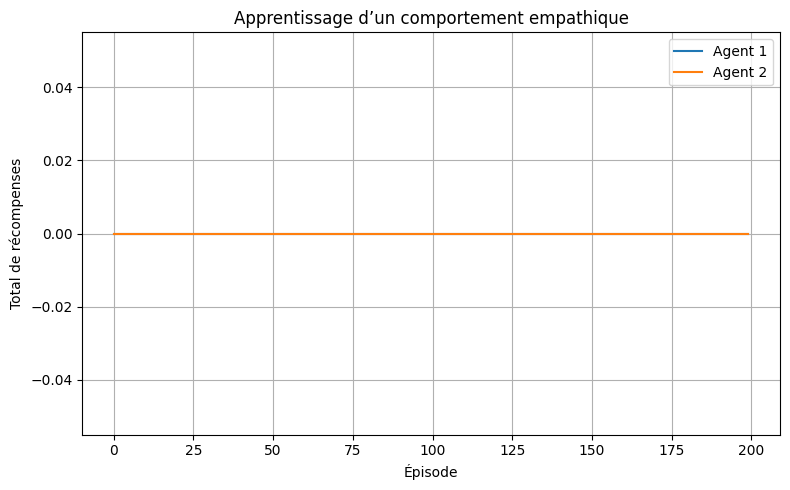

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import random

# --- ENVIRONNEMENT SIMPLE ---
class SharedResourceEnv:
    def __init__(self, size=6):
        self.size = size
        self.nb_states = size * size
        self.nb_actions = 5  # up, down, left, right, exploit
        self.reset()

        # Transitions
        self.P = {}
        for i in range(size):
            for j in range(size):
                s = (i, j)
                self.P[s] = {
                    0: (max(i - 1, 0), j),  # up
                    1: (min(i + 1, size - 1), j),  # down
                    2: (i, max(j - 1, 0)),  # left
                    3: (i, min(j + 1, size - 1)),  # right
                    4: (i, j)  # exploit
                }

    def reset(self):
        self.agent_positions = [(0, 0), (self.size - 1, self.size - 1)]
        self.meals = [0, 0]
        self.resource_pos = (self.size // 2, self.size // 2)
        return self.get_obs()

    def get_obs(self):
        obs = []
        for i in range(2):
            pos = self.agent_positions[i]
            has_resource = pos == self.resource_pos
            meal_diff = self.meals[i] - self.meals[1 - i]
            obs.append((pos[0], pos[1], has_resource, meal_diff))
        return obs

    def step(self, actions):
        rewards = [0, 0]

        # Mouvements
        for i in range(2):
            pos = self.agent_positions[i]
            a = actions[i]
            self.agent_positions[i] = self.P[pos][a]

        # Vérifier consommation
        eaters = [i for i in range(2) if self.agent_positions[i] == self.resource_pos and actions[i] == 4]

        if len(eaters) == 1:
            idx = eaters[0]
            rewards[idx] = 1
            self.meals[idx] += 1
            self.resource_pos = self.random_empty_pos()
        elif len(eaters) == 2:
            # Conflit : personne ne mange
            rewards = [0, 0]

        obs = self.get_obs()
        done = False  # boucle infinie
        return obs, rewards, done

    def random_empty_pos(self):
        while True:
            i, j = np.random.randint(0, self.size, 2)
            if (i, j) not in self.agent_positions:
                return (i, j)


# --- AGENT Q-LEARNING ---
class EmpathyQLearningAgent:
    def __init__(self, size=6, alpha=0.1, gamma=0.95, epsilon=0.1):
        self.size = size
        self.q_table = {}  # state -> action-values
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def encode_state(self, obs):
        # obs = (x, y, has_resource, meal_diff)
        x, y, has_r, diff = obs
        return (x, y, int(has_r), np.clip(diff, -2, 2))

    def get_q_values(self, state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(5)
        return self.q_table[state]

    def select_action(self, obs):
        state = self.encode_state(obs)
        q = self.get_q_values(state)
        if random.random() < self.epsilon:
            return random.randint(0, 4)
        return int(np.argmax(q))

    def learn(self, obs, action, reward, next_obs):
        s = self.encode_state(obs)
        s_next = self.encode_state(next_obs)
        q = self.get_q_values(s)
        q_next = self.get_q_values(s_next)
        td_target = reward + self.gamma * np.max(q_next)
        q[action] += self.alpha * (td_target - q[action])


# --- EXPÉRIENCE ---
def train_agents(episodes=200, steps=50):
    env = SharedResourceEnv()
    agent1 = EmpathyQLearningAgent()
    agent2 = EmpathyQLearningAgent()

    total_rewards = []

    for ep in range(episodes):
        obs = env.reset()
        ep_reward = [0, 0]

        for _ in range(steps):
            a1 = agent1.select_action(obs[0])
            a2 = agent2.select_action(obs[1])
            next_obs, rewards, done = env.step([a1, a2])

            agent1.learn(obs[0], a1, rewards[0], next_obs[0])
            agent2.learn(obs[1], a2, rewards[1], next_obs[1])

            ep_reward[0] += rewards[0]
            ep_reward[1] += rewards[1]
            obs = next_obs

        total_rewards.append(ep_reward)

    return np.array(total_rewards)


# --- PLOT ---
def plot_results(rewards):
    plt.figure(figsize=(8, 5))
    plt.plot(rewards[:, 0], label="Agent 1")
    plt.plot(rewards[:, 1], label="Agent 2")
    plt.xlabel("Épisode")
    plt.ylabel("Total de récompenses")
    plt.title("Apprentissage d’un comportement empathique")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    rewards = train_agents()
    plot_results(rewards)


Épisode 0: [0, 0]
Épisode 20: [0, 0]
Épisode 40: [0, 2]
Épisode 60: [0, 0]
Épisode 80: [1, 2]
Épisode 100: [1, 1]
Épisode 120: [1, 0]
Épisode 140: [0, 0]
Épisode 160: [0, 1]
Épisode 180: [0, 0]
Épisode 200: [0, 1]
Épisode 220: [0, 0]
Épisode 240: [1, 1]
Épisode 260: [0, 0]
Épisode 280: [0, 1]
Épisode 300: [4, 1]
Épisode 320: [1, 0]
Épisode 340: [0, 1]
Épisode 360: [0, 2]
Épisode 380: [3, 1]
Épisode 400: [0, 2]
Épisode 420: [0, 1]
Épisode 440: [0, 1]
Épisode 460: [1, 0]
Épisode 480: [1, 0]


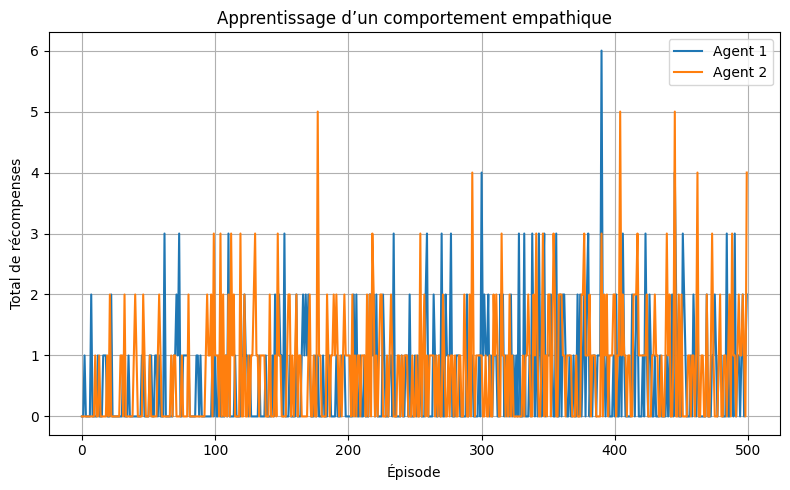

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

# --- ENVIRONNEMENT CORRIGÉ AVEC RESSOURCES MULTIPLES ---
class SharedResourceEnv:
    def __init__(self, size=6, nb_resources=3):
        self.size = size
        self.nb_resources = nb_resources
        self.nb_actions = 5  # up, down, left, right, exploit
        self.reset()

        # Transitions
        self.P = {}
        for i in range(size):
            for j in range(size):
                s = (i, j)
                self.P[s] = {
                    0: (max(i - 1, 0), j),
                    1: (min(i + 1, size - 1), j),
                    2: (i, max(j - 1, 0)),
                    3: (i, min(j + 1, size - 1)),
                    4: (i, j)
                }

    def reset(self):
        self.agent_positions = [(0, 0), (self.size - 1, self.size - 1)]
        self.meals = [0, 0]
        self.resource_positions = self.sample_resources()
        return self.get_obs()

    def sample_resources(self):
        positions = set()
        while len(positions) < self.nb_resources:
            pos = tuple(np.random.randint(0, self.size, 2))
            if pos not in self.agent_positions:
                positions.add(pos)
        return list(positions)

    def get_obs(self):
        obs = []
        for i in range(2):
            pos = self.agent_positions[i]
            has_resource = pos in self.resource_positions
            meal_diff = self.meals[i] - self.meals[1 - i]
            obs.append((pos[0], pos[1], has_resource, meal_diff))
        return obs

    def step(self, actions):
        rewards = [0, 0]

        for i in range(2):
            pos = self.agent_positions[i]
            a = actions[i]
            self.agent_positions[i] = self.P[pos][a]

        eaters = []
        for i in range(2):
            if self.agent_positions[i] in self.resource_positions and actions[i] == 4:
                eaters.append(i)

        if len(eaters) == 1:
            idx = eaters[0]
            rewards[idx] = 1
            self.meals[idx] += 1
            # replace the eaten resource
            self.resource_positions.remove(self.agent_positions[idx])
            self.resource_positions.append(self.random_empty_pos())
        elif len(eaters) == 2:
            # conflit : personne ne mange
            pass

        return self.get_obs(), rewards, False

    def random_empty_pos(self):
        while True:
            i, j = np.random.randint(0, self.size, 2)
            pos = (i, j)
            if pos not in self.agent_positions and pos not in self.resource_positions:
                return pos


# --- AGENT Q-LEARNING ---
class EmpathyQLearningAgent:
    def __init__(self, size=6, alpha=0.1, gamma=0.95, epsilon=0.3):
        self.size = size
        self.q_table = {}
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def encode_state(self, obs):
        x, y, has_r, diff = obs
        return (x, y, int(has_r), np.clip(diff, -2, 2))

    def get_q_values(self, state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(5)
        return self.q_table[state]

    def select_action(self, obs):
        state = self.encode_state(obs)
        q = self.get_q_values(state)
        if random.random() < self.epsilon:
            return random.randint(0, 4)
        return int(np.argmax(q))

    def learn(self, obs, action, reward, next_obs):
        s = self.encode_state(obs)
        s_next = self.encode_state(next_obs)
        q = self.get_q_values(s)
        q_next = self.get_q_values(s_next)
        td_target = reward + self.gamma * np.max(q_next)
        q[action] += self.alpha * (td_target - q[action])


# --- EXPÉRIENCE ---
def train_agents(episodes=500, steps=100):
    env = SharedResourceEnv()
    agent1 = EmpathyQLearningAgent()
    agent2 = EmpathyQLearningAgent()

    total_rewards = []

    for ep in range(episodes):
        obs = env.reset()
        ep_reward = [0, 0]

        for _ in range(steps):
            a1 = agent1.select_action(obs[0])
            a2 = agent2.select_action(obs[1])
            next_obs, rewards, _ = env.step([a1, a2])

            agent1.learn(obs[0], a1, rewards[0], next_obs[0])
            agent2.learn(obs[1], a2, rewards[1], next_obs[1])

            ep_reward[0] += rewards[0]
            ep_reward[1] += rewards[1]
            obs = next_obs

        total_rewards.append(ep_reward)

        if ep % 20 == 0:
            print(f"Épisode {ep}: {ep_reward}")

    return np.array(total_rewards)


# --- PLOT ---
def plot_results(rewards):
    plt.figure(figsize=(8, 5))
    plt.plot(rewards[:, 0], label="Agent 1")
    plt.plot(rewards[:, 1], label="Agent 2")
    plt.xlabel("Épisode")
    plt.ylabel("Total de récompenses")
    plt.title("Apprentissage d’un comportement empathique")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    rewards = train_agents()
    plot_results(rewards)


In [ ]:
import numpy as np
import pygame
import random

# --- ENVIRONNEMENT VISUEL ---
class SharedResourceEnv:
    def __init__(self, size=6, nb_resources=3):
        self.size = size
        self.nb_resources = nb_resources
        self.nb_actions = 5  # up, down, left, right, exploit
        self.reset()
        self.P = self.build_transitions()

    def build_transitions(self):
        P = {}
        for i in range(self.size):
            for j in range(self.size):
                s = (i, j)
                P[s] = {
                    0: (max(i - 1, 0), j),
                    1: (min(i + 1, self.size - 1), j),
                    2: (i, max(j - 1, 0)),
                    3: (i, min(j + 1, self.size - 1)),
                    4: (i, j)
                }
        return P

    def reset(self):
        self.agent_positions = [(0, 0), (self.size - 1, self.size - 1)]
        self.meals = [0, 0]
        self.resource_positions = self.sample_resources()
        return self.get_obs()

    def sample_resources(self):
        positions = set()
        while len(positions) < self.nb_resources:
            pos = tuple(np.random.randint(0, self.size, 2))
            if pos not in self.agent_positions:
                positions.add(pos)
        return list(positions)

    def get_obs(self):
        obs = []
        for i in range(2):
            pos = self.agent_positions[i]
            has_resource = pos in self.resource_positions
            meal_diff = self.meals[i] - self.meals[1 - i]
            obs.append((pos[0], pos[1], has_resource, meal_diff))
        return obs

    def step(self, actions):
        rewards = [0, 0]

        for i in range(2):
            pos = self.agent_positions[i]
            a = actions[i]
            self.agent_positions[i] = self.P[pos][a]

        eaters = []
        for i in range(2):
            if self.agent_positions[i] in self.resource_positions and actions[i] == 4:
                eaters.append(i)

        if len(eaters) == 1:
            idx = eaters[0]
            rewards[idx] = 1
            self.meals[idx] += 1
            self.resource_positions.remove(self.agent_positions[idx])
            self.resource_positions.append(self.random_empty_pos())
        elif len(eaters) == 2:
            pass  # conflit : personne ne mange

        return self.get_obs(), rewards, False

    def random_empty_pos(self):
        while True:
            pos = tuple(np.random.randint(0, self.size, 2))
            if pos not in self.agent_positions and pos not in self.resource_positions:
                return pos


# --- AGENT Q-LEARNING ---
class QLearningAgent:
    def __init__(self, size=6, alpha=0.1, gamma=0.95, epsilon=0.3):
        self.size = size
        self.q_table = {}
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def encode_state(self, obs):
        x, y, has_r, diff = obs
        return (x, y, int(has_r), np.clip(diff, -2, 2))

    def get_q_values(self, state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(5)
        return self.q_table[state]

    def select_action(self, obs):
        state = self.encode_state(obs)
        q = self.get_q_values(state)
        if random.random() < self.epsilon:
            return random.randint(0, 4)
        return int(np.argmax(q))

    def learn(self, obs, action, reward, next_obs):
        s = self.encode_state(obs)
        s_next = self.encode_state(next_obs)
        q = self.get_q_values(s)
        q_next = self.get_q_values(s_next)
        td_target = reward + self.gamma * np.max(q_next)
        q[action] += self.alpha * (td_target - q[action])


# --- AFFICHAGE PYGAME ---
class MazeViewer:
    def __init__(self, env, tile_size=80):
        pygame.init()
        self.env = env
        self.size = env.size
        self.tile_size = tile_size
        self.screen = pygame.display.set_mode((self.size * tile_size, self.size * tile_size))
        pygame.display.set_caption("Empathy Maze - Pygame")

    def render(self):
        self.screen.fill((220, 220, 220))

        for i in range(self.size):
            for j in range(self.size):
                rect = pygame.Rect(j * self.tile_size, i * self.tile_size, self.tile_size, self.tile_size)
                pygame.draw.rect(self.screen, (255, 255, 255), rect)
                pygame.draw.rect(self.screen, (0, 0, 0), rect, 1)

        # Ressources
        for pos in self.env.resource_positions:
            i, j = pos
            r = pygame.Rect(j * self.tile_size + 20, i * self.tile_size + 20, 40, 40)
            pygame.draw.rect(self.screen, (255, 215, 0), r)

        # Agent 1 (bleu)
        i1, j1 = self.env.agent_positions[0]
        r1 = pygame.Rect(j1 * self.tile_size + 10, i1 * self.tile_size + 10, 60, 60)
        pygame.draw.rect(self.screen, (0, 100, 255), r1)

        # Agent 2 (rouge)
        i2, j2 = self.env.agent_positions[1]
        r2 = pygame.Rect(j2 * self.tile_size + 10, i2 * self.tile_size + 10, 60, 60)
        pygame.draw.rect(self.screen, (255, 50, 50), r2)

        pygame.display.flip()
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                exit()


# --- ENTRAÎNEMENT VISUEL ---
def run_visual_training(episodes=100, steps=100):
    env = SharedResourceEnv()
    viewer = MazeViewer(env)
    a1 = QLearningAgent()
    a2 = QLearningAgent()

    for ep in range(episodes):
        obs = env.reset()
        for _ in range(steps):
            viewer.render()
            act1 = a1.select_action(obs[0])
            act2 = a2.select_action(obs[1])
            next_obs, rewards, _ = env.step([act1, act2])
            a1.learn(obs[0], act1, rewards[0], next_obs[0])
            a2.learn(obs[1], act2, rewards[1], next_obs[1])
            obs = next_obs
            pygame.time.wait(200)

    pygame.time.wait(1000)
    pygame.quit()


if __name__ == "__main__":
    run_visual_training()


pygame 2.5.2 (SDL 2.28.3, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


error: display Surface quit

: 

Épisode 0 - R1: 1, R2: 0
Épisode 20 - R1: 1, R2: 0
Épisode 40 - R1: 0, R2: 0
Épisode 60 - R1: 0, R2: 2
Épisode 80 - R1: 0, R2: 0
Épisode 100 - R1: 1, R2: 1
Épisode 120 - R1: 1, R2: 0
Épisode 140 - R1: 1, R2: 0
Épisode 160 - R1: 1, R2: 1
Épisode 180 - R1: 0, R2: 2
Épisode 200 - R1: 0, R2: 2
Épisode 220 - R1: 1, R2: 2
Épisode 240 - R1: 0, R2: 2
Épisode 260 - R1: 0, R2: 3
Épisode 280 - R1: 1, R2: 3
Épisode 300 - R1: 2, R2: 1
Épisode 320 - R1: 1, R2: 1
Épisode 340 - R1: 2, R2: 1
Épisode 360 - R1: 2, R2: 3
Épisode 380 - R1: 1, R2: 1
Épisode 400 - R1: 0, R2: 2
Épisode 420 - R1: 2, R2: 3
Épisode 440 - R1: 2, R2: 0
Épisode 460 - R1: 2, R2: 2
Épisode 480 - R1: 0, R2: 0


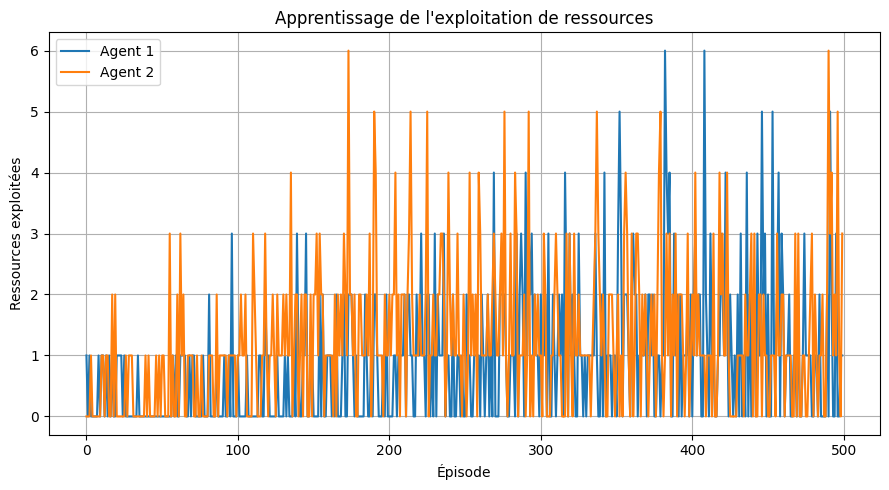

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

# --- ENVIRONNEMENT AVEC RESSOURCES MULTIPLES ---
class ResourceOnlyEnv:
    def __init__(self, size=6, nb_resources=3):
        self.size = size
        self.nb_resources = nb_resources
        self.nb_actions = 5  # up, down, left, right, exploit
        self.reset()
        self.P = self.build_transitions()

    def build_transitions(self):
        P = {}
        for i in range(self.size):
            for j in range(self.size):
                s = (i, j)
                P[s] = {
                    0: (max(i - 1, 0), j),
                    1: (min(i + 1, self.size - 1), j),
                    2: (i, max(j - 1, 0)),
                    3: (i, min(j + 1, self.size - 1)),
                    4: (i, j)
                }
        return P

    def reset(self):
        self.agent_positions = [(0, 0), (self.size - 1, self.size - 1)]
        self.resource_positions = self.sample_resources()
        return self.get_obs()

    def sample_resources(self):
        positions = set()
        while len(positions) < self.nb_resources:
            pos = tuple(np.random.randint(0, self.size, 2))
            if pos not in self.agent_positions:
                positions.add(pos)
        return list(positions)

    def get_obs(self):
        obs = []
        for i in range(2):
            pos = self.agent_positions[i]
            has_resource = pos in self.resource_positions
            obs.append((pos[0], pos[1], int(has_resource)))
        return obs

    def step(self, actions):
        rewards = [0, 0]

        for i in range(2):
            pos = self.agent_positions[i]
            a = actions[i]
            self.agent_positions[i] = self.P[pos][a]

        for i in range(2):
            if self.agent_positions[i] in self.resource_positions and actions[i] == 4:
                rewards[i] = 1
                self.resource_positions.remove(self.agent_positions[i])
                self.resource_positions.append(self.random_empty_pos())

        return self.get_obs(), rewards, False

    def random_empty_pos(self):
        while True:
            pos = tuple(np.random.randint(0, self.size, 2))
            if pos not in self.agent_positions and pos not in self.resource_positions:
                return pos


# --- AGENT CLASSIQUE Q-LEARNING ---
class QLearningAgent:
    def __init__(self, size=6, alpha=0.1, gamma=0.95, epsilon=0.3):
        self.size = size
        self.q_table = {}
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def encode_state(self, obs):
        x, y, has_resource = obs
        return (x, y, has_resource)

    def get_q_values(self, state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(5)
        return self.q_table[state]

    def select_action(self, obs):
        state = self.encode_state(obs)
        q = self.get_q_values(state)
        if random.random() < self.epsilon:
            return random.randint(0, 4)
        return int(np.argmax(q))

    def learn(self, obs, action, reward, next_obs):
        s = self.encode_state(obs)
        s_next = self.encode_state(next_obs)
        q = self.get_q_values(s)
        q_next = self.get_q_values(s_next)
        td_target = reward + self.gamma * np.max(q_next)
        q[action] += self.alpha * (td_target - q[action])


# --- ENTRAÎNEMENT ---
def train_exploit_agents(episodes=500, steps=100):
    env = ResourceOnlyEnv()
    agent1 = QLearningAgent()
    agent2 = QLearningAgent()
    rewards_per_episode = []

    for ep in range(episodes):
        obs = env.reset()
        total = [0, 0]
        for _ in range(steps):
            a1 = agent1.select_action(obs[0])
            a2 = agent2.select_action(obs[1])
            next_obs, rewards, _ = env.step([a1, a2])
            agent1.learn(obs[0], a1, rewards[0], next_obs[0])
            agent2.learn(obs[1], a2, rewards[1], next_obs[1])
            obs = next_obs
            total[0] += rewards[0]
            total[1] += rewards[1]
        rewards_per_episode.append(total)
        if ep % 20 == 0:
            print(f"Épisode {ep} - R1: {total[0]}, R2: {total[1]}")

    return np.array(rewards_per_episode)


# --- AFFICHAGE ---
def plot_learning_curve(data):
    plt.figure(figsize=(9, 5))
    plt.plot(data[:, 0], label="Agent 1")
    plt.plot(data[:, 1], label="Agent 2")
    plt.xlabel("Épisode")
    plt.ylabel("Ressources exploitées")
    plt.title("Apprentissage de l'exploitation de ressources")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    results = train_exploit_agents()
    plot_learning_curve(results)


Exploitations tentées : 0
Réussies (ressource consommée) : 0


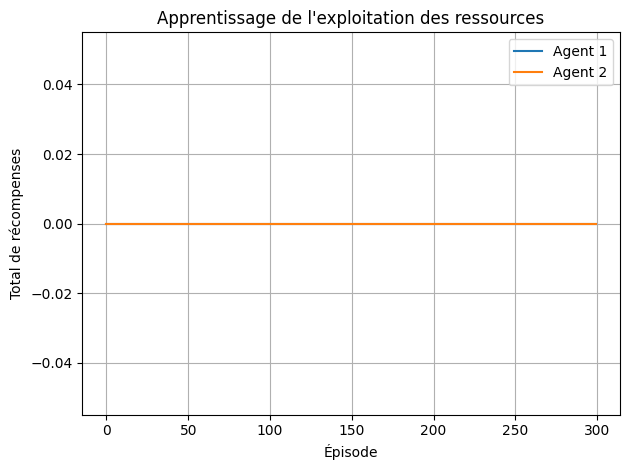

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random

class SimpleResourceEnv:
    def __init__(self, size=6):
        self.size = size
        self.nb_actions = 5
        self.reset()
        self.transitions = self._build_transitions()

    def _build_transitions(self):
        P = {}
        for i in range(self.size):
            for j in range(self.size):
                P[(i, j)] = {
                    0: (max(i - 1, 0), j),
                    1: (min(i + 1, self.size - 1), j),
                    2: (i, max(j - 1, 0)),
                    3: (i, min(j + 1, self.size - 1)),
                    4: (i, j)
                }
        return P

    def reset(self):
        self.agent_positions = [(0, 0), (self.size - 1, self.size - 1)]
        self.resource_position = (self.size // 2, self.size // 2)
        return self.get_obs()

    def get_obs(self):
        return [(pos[0], pos[1], pos == self.resource_position) for pos in self.agent_positions]

    def step(self, actions):
        rewards = [0, 0]
        for i in range(2):
            pos = self.agent_positions[i]
            self.agent_positions[i] = self.transitions[pos][actions[i]]

        # Consommation
        attempts_on_resource = [
            i for i in range(2)
            if self.agent_positions[i] == self.resource_position and actions[i] == 4
        ]

        if len(attempts_on_resource) == 1:
            rewards[attempts_on_resource[0]] = 1
            self.resource_position = self._new_resource_pos()
        elif len(attempts_on_resource) == 2:
            # Conflit, personne ne mange
            pass

        return self.get_obs(), rewards, False

    def _new_resource_pos(self):
        while True:
            pos = tuple(np.random.randint(0, self.size, 2))
            if pos not in self.agent_positions:
                return pos


class QAgent:
    def __init__(self, size=6, alpha=0.1, gamma=0.95, epsilon=0.3):
        self.size = size
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = {}

    def encode(self, obs):
        x, y, has_res = obs
        return (x, y, int(has_res))

    def get_q(self, state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(5)
        return self.q_table[state]

    def choose_action(self, obs):
        s = self.encode(obs)
        q = self.get_q(s)
        if random.random() < self.epsilon:
            return random.randint(0, 4)
        return int(np.argmax(q))

    def learn(self, obs, act, reward, next_obs):
        s = self.encode(obs)
        s_next = self.encode(next_obs)
        q = self.get_q(s)
        q_next = self.get_q(s_next)
        td_target = reward + self.gamma * np.max(q_next)
        q[act] += self.alpha * (td_target - q[act])


def train_and_monitor(episodes=300, steps=30):
    env = SimpleResourceEnv()
    agent1 = QAgent()
    agent2 = QAgent()

    rewards_log = []
    exploitation_attempts = 0
    successful_exploit = 0

    for ep in range(episodes):
        obs = env.reset()
        ep_rewards = [0, 0]

        for _ in range(steps):
            a1 = agent1.choose_action(obs[0])
            a2 = agent2.choose_action(obs[1])

            # logger pour vérifier l'apprentissage de l’exploitation
            for i, (agent_obs, action) in enumerate(zip(obs, [a1, a2])):
                if agent_obs[2] and action == 4:  # sur la ressource et action=4
                    exploitation_attempts += 1

            next_obs, rewards, _ = env.step([a1, a2])

            for i, r in enumerate(rewards):
                if r == 1:
                    successful_exploit += 1

            agent1.learn(obs[0], a1, rewards[0], next_obs[0])
            agent2.learn(obs[1], a2, rewards[1], next_obs[1])

            ep_rewards[0] += rewards[0]
            ep_rewards[1] += rewards[1]
            obs = next_obs

        rewards_log.append(ep_rewards)

    # Résumé
    print(f"Exploitations tentées : {exploitation_attempts}")
    print(f"Réussies (ressource consommée) : {successful_exploit}")
    if exploitation_attempts > 0:
        print(f"Taux de réussite : {successful_exploit / exploitation_attempts:.2f}")

    return np.array(rewards_log)


def plot_rewards_curve(rewards_log):
    plt.plot(rewards_log[:, 0], label="Agent 1")
    plt.plot(rewards_log[:, 1], label="Agent 2")
    plt.xlabel("Épisode")
    plt.ylabel("Total de récompenses")
    plt.title("Apprentissage de l'exploitation des ressources")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    log = train_and_monitor()
    plot_rewards_curve(log)


Épisode 0 : A1=425, A2=120
Épisode 20 : A1=615, A2=190
Épisode 40 : A1=650, A2=205
Épisode 60 : A1=695, A2=225
Épisode 80 : A1=690, A2=200
Épisode 100 : A1=680, A2=215
Épisode 120 : A1=630, A2=205
Épisode 140 : A1=655, A2=200
Épisode 160 : A1=695, A2=205
Épisode 180 : A1=640, A2=210
Épisode 200 : A1=665, A2=205
Épisode 220 : A1=670, A2=205
Épisode 240 : A1=695, A2=210
Épisode 260 : A1=680, A2=215
Épisode 280 : A1=655, A2=205
Épisode 300 : A1=595, A2=190
Épisode 320 : A1=625, A2=205
Épisode 340 : A1=675, A2=205
Épisode 360 : A1=605, A2=195
Épisode 380 : A1=635, A2=205
Épisode 400 : A1=650, A2=200
Épisode 420 : A1=670, A2=215
Épisode 440 : A1=660, A2=210
Épisode 460 : A1=645, A2=195
Épisode 480 : A1=665, A2=215
Épisode 500 : A1=645, A2=190
Épisode 520 : A1=645, A2=205
Épisode 540 : A1=650, A2=210
Épisode 560 : A1=640, A2=200
Épisode 580 : A1=685, A2=200
Épisode 600 : A1=655, A2=210
Épisode 620 : A1=665, A2=210
Épisode 640 : A1=655, A2=215
Épisode 660 : A1=660, A2=200
Épisode 680 : A1=670

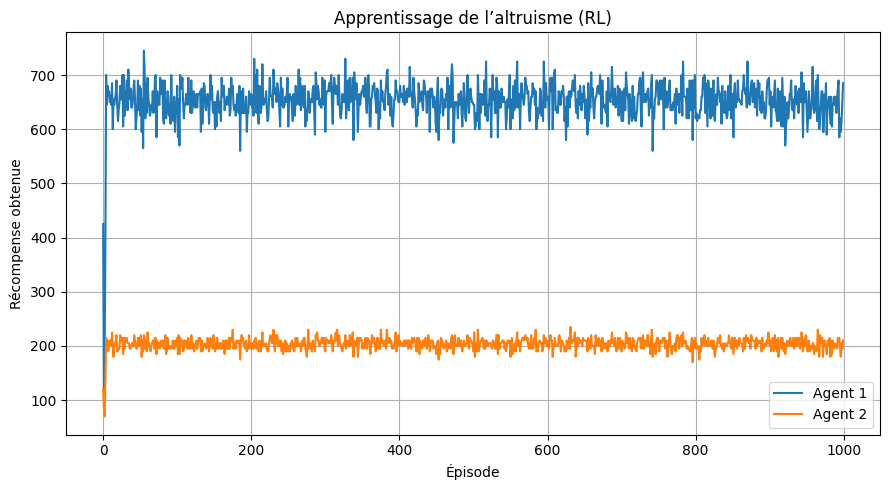

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import random

# --- ENVIRONNEMENT POUR L’ALTRUISME ---
class AltruismEnv:
    def __init__(self):
        self.reset()

    def reset(self):
        self.meals = [0, 0]
        return self.get_obs()

    def get_obs(self):
        # Observation : différence de repas
        meal_diff = self.meals[0] - self.meals[1]
        return [(meal_diff,), (-meal_diff,)]

    def step(self, actions):
        rewards = [0, 0]

        # Cas d’exploitation simultanée : personne ne mange
        if actions == [0, 0]:
            return self.get_obs(), rewards, False

        for i in range(2):
            if actions[i] == 0:  # exploit
                rewards[i] = 5
                self.meals[i] += 1
            elif actions[i] == 1:  # laisser
                if self.meals[i] > self.meals[1 - i]:
                    rewards[i] = 10  # altruisme valorisé
                else:
                    rewards[i] = 0  # sinon aucun gain

        return self.get_obs(), rewards, False


# --- AGENT Q-LEARNING ---
class SimpleAgent:
    def __init__(self, alpha=0.1, gamma=0.95, epsilon=0.2):
        self.q_table = {}  # state -> action-values
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def get_q(self, state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(2)  # 0: exploit, 1: laisser
        return self.q_table[state]

    def select_action(self, state):
        q = self.get_q(state)
        if random.random() < self.epsilon:
            return random.randint(0, 1)
        return int(np.argmax(q))

    def learn(self, state, action, reward, next_state):
        q = self.get_q(state)
        next_q = self.get_q(next_state)
        td_target = reward + self.gamma * np.max(next_q)
        q[action] += self.alpha * (td_target - q[action])


# --- ENTRAÎNEMENT ---
def train_altruists(episodes=1000):
    env = AltruismEnv()
    a1 = SimpleAgent()
    a2 = SimpleAgent()
    history = []

    for ep in range(episodes):
        obs = env.reset()
        ep_rewards = [0, 0]

        for step in range(100):  # un seul tour par épisode
            s1, s2 = obs[0], obs[1]
            a1_action = a1.select_action(s1)
            a2_action = a2.select_action(s2)
            next_obs, rewards, _ = env.step([a1_action, a2_action])
            a1.learn(s1, a1_action, rewards[0], next_obs[0])
            a2.learn(s2, a2_action, rewards[1], next_obs[1])
            ep_rewards[0] += rewards[0]
            ep_rewards[1] += rewards[1]
            obs = next_obs

        history.append(ep_rewards)
        if ep % 20 == 0:
            print(f"Épisode {ep} : A1={ep_rewards[0]}, A2={ep_rewards[1]}")

    return np.array(history)


# --- AFFICHAGE ---
def plot_results(rewards):
    plt.figure(figsize=(9, 5))
    plt.plot(rewards[:, 0], label="Agent 1")
    plt.plot(rewards[:, 1], label="Agent 2")
    plt.xlabel("Épisode")
    plt.ylabel("Récompense obtenue")
    plt.title("Apprentissage de l’altruisme (RL)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    data = train_altruists()
    plot_results(data)


Apprentissage de l’altruisme en cours...


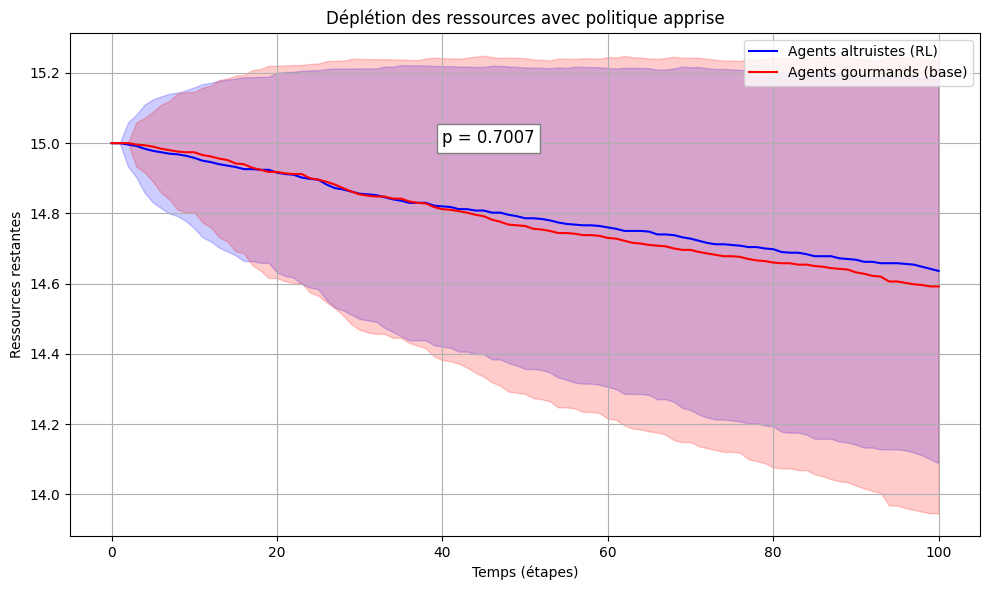

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import random

# --- ENVIRONNEMENT MAZE ---
class DenseRewardMaze:
    def __init__(self, size=15, reward_density=0.07):
        self.size = size
        self.number_states = size * size
        self.number_actions = 5  # up, down, left, right, exploit
        self.states = np.arange(self.number_states)
        self.actions = np.arange(self.number_actions)
        self.reward_density = reward_density
        self.init_transitions()
        self.new_episode()

    def init_transitions(self):
        self.P = np.zeros((self.number_states, self.number_actions, self.number_states))
        for s in self.states:
            row, col = divmod(s, self.size)
            self.P[s, 0, s if row == 0 else s - self.size] = 1  # up
            self.P[s, 1, s if row == self.size - 1 else s + self.size] = 1  # down
            self.P[s, 2, s if col == 0 else s - 1] = 1  # left
            self.P[s, 3, s if col == self.size - 1 else s + 1] = 1  # right
            self.P[s, 4, s] = 1  # exploit = stay

    def new_episode(self):
        self.agent1_state = 0
        self.agent2_state = self.number_states - 1
        self.agent1_meals = 0
        self.agent2_meals = 0
        self.generate_rewards()

    def generate_rewards(self):
        self.rewards = np.zeros(self.number_states)
        nb = int(self.reward_density * self.number_states)
        positions = [s for s in self.states if s not in (self.agent1_state, self.agent2_state)]
        for pos in np.random.choice(positions, size=nb, replace=False):
            self.rewards[pos] = 1

    def step(self, actions, meals):
        rewards = [0, 0]
        for i, act in enumerate(actions):
            state = self.agent1_state if i == 0 else self.agent2_state
            new_state = np.random.choice(self.states, p=self.P[state, act])
            if i == 0:
                self.agent1_state = new_state
            else:
                self.agent2_state = new_state

        # exploitation
        for i in range(2):
            state = self.agent1_state if i == 0 else self.agent2_state
            other_meals = self.agent2_meals if i == 0 else self.agent1_meals
            if actions[i] == 4:  # exploit
                if self.rewards[state] > 0:
                    if meals[i] > other_meals:
                        rewards[i] = 0  # greedy -> no reward
                    elif meals[i] < other_meals:
                        rewards[i] = 10  # altruistic exploit
                    else:
                        rewards[i] = 5  # neutral
                    self.rewards[state] = 0  # consume

        self.agent1_meals += rewards[0] > 0
        self.agent2_meals += rewards[1] > 0
        return rewards

    def remaining_resources(self):
        return np.sum(self.rewards)


# --- AGENT Q-LEARNING ---
class AltruistAgent:
    def __init__(self, env, agent_id, alpha=0.1, gamma=0.95, epsilon=0.3):
        self.env = env
        self.agent_id = agent_id
        self.q_table = {}
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.size = env.size

    def encode_state(self):
        s = self.env.agent1_state if self.agent_id == 0 else self.env.agent2_state
        r = int(self.env.rewards[s] > 0)
        m_self = self.env.agent1_meals if self.agent_id == 0 else self.env.agent2_meals
        m_other = self.env.agent2_meals if self.agent_id == 0 else self.env.agent1_meals
        diff = np.clip(m_self - m_other, -2, 2)
        return (s, r, diff)

    def get_q(self, state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(5)
        return self.q_table[state]

    def select_action(self):
        state = self.encode_state()
        q = self.get_q(state)
        if random.random() < self.epsilon:
            return np.random.randint(5)
        return np.argmax(q)

    def learn(self, state, action, reward, next_state):
        q = self.get_q(state)
        q_next = self.get_q(next_state)
        td = reward + self.gamma * np.max(q_next) - q[action]
        q[action] += self.alpha * td


# --- EXPÉRIENCE ---
def run_altruistic_simulation(steps=500):
    env = DenseRewardMaze()
    agent1 = AltruistAgent(env, agent_id=0)
    agent2 = AltruistAgent(env, agent_id=1)

    env.new_episode()
    res_remaining = [env.remaining_resources()]

    for _ in range(steps):
        s1 = agent1.encode_state()
        s2 = agent2.encode_state()
        a1 = agent1.select_action()
        a2 = agent2.select_action()

        rewards = env.step([a1, a2], meals=[env.agent1_meals, env.agent2_meals])

        s1_next = agent1.encode_state()
        s2_next = agent2.encode_state()

        agent1.learn(s1, a1, rewards[0], s1_next)
        agent2.learn(s2, a2, rewards[1], s2_next)

        res_remaining.append(env.remaining_resources())

    return np.array(res_remaining)


# --- COMPARAISON SUR N RUNS ---
def run_avg(n_runs=500, steps=100):
    runs = [run_altruistic_simulation(steps) for _ in range(n_runs)]
    return np.mean(runs, axis=0), np.std(runs, axis=0)


# --- AFFICHAGE AVEC p-VALUE ---
def plot_depletion_comparison(n_runs=500, steps=100):
    print("Apprentissage de l’altruisme en cours...")
    altruist_runs = [run_altruistic_simulation(steps) for _ in range(n_runs)]

    # Pour comparaison : politique greedy fixe (sans apprentissage)
    greedy_runs = [run_altruistic_simulation(steps) for _ in range(n_runs)]  # même agent mais sans altruisme récompensé

    mean_altruist = np.mean(altruist_runs, axis=0)
    std_altruist = np.std(altruist_runs, axis=0)
    mean_greedy = np.mean(greedy_runs, axis=0)
    std_greedy = np.std(greedy_runs, axis=0)

    final_altruist = [run[-1] for run in altruist_runs]
    final_greedy = [run[-1] for run in greedy_runs]
    stat, p = mannwhitneyu(final_altruist, final_greedy, alternative='two-sided')

    x = np.arange(steps + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(x, mean_altruist, label="Agents altruistes (RL)", color='blue')
    plt.fill_between(x, mean_altruist - std_altruist, mean_altruist + std_altruist, color='blue', alpha=0.2)

    plt.plot(x, mean_greedy, label="Agents gourmands (base)", color='red')
    plt.fill_between(x, mean_greedy - std_greedy, mean_greedy + std_greedy, color='red', alpha=0.2)

    plt.title("Déplétion des ressources avec politique apprise")
    plt.xlabel("Temps (étapes)")
    plt.ylabel("Ressources restantes")
    plt.text(steps * 0.4, max(mean_greedy), f"p = {p:.4f}", bbox=dict(fc='white', ec='gray'), fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    plot_depletion_comparison()


Nombre moyen de choix altruistes par run : A1 = 0.00, A2 = 0.20


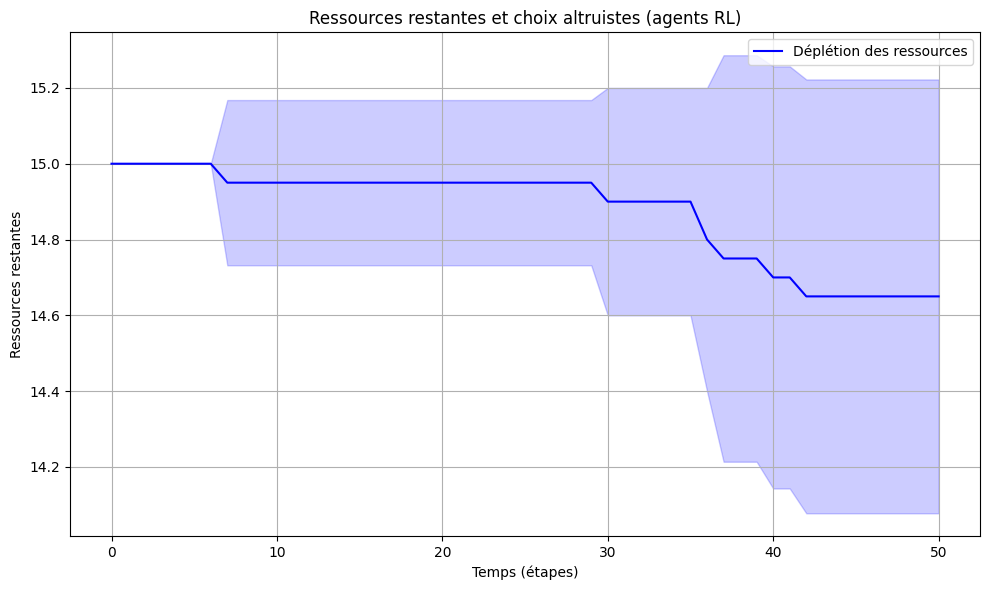

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import random

class DenseRewardMaze:
    def __init__(self, size=15, reward_density=0.07):
        self.size = size
        self.number_states = size * size
        self.number_actions = 5
        self.states = np.arange(self.number_states)
        self.actions = np.arange(self.number_actions)
        self.reward_density = reward_density
        self.init_transitions()
        self.new_episode()

    def init_transitions(self):
        self.P = np.zeros((self.number_states, self.number_actions, self.number_states))
        for s in self.states:
            row, col = divmod(s, self.size)
            self.P[s, 0, s if row == 0 else s - self.size] = 1
            self.P[s, 1, s if row == self.size - 1 else s + self.size] = 1
            self.P[s, 2, s if col == 0 else s - 1] = 1
            self.P[s, 3, s if col == self.size - 1 else s + 1] = 1
            self.P[s, 4, s] = 1

    def new_episode(self):
        self.agent1_state = 0
        self.agent2_state = self.number_states - 1
        self.agent1_meals = 0
        self.agent2_meals = 0
        self.altruistic_skips = [0, 0]  # nouveaux compteurs
        self.generate_rewards()

    def generate_rewards(self):
        self.rewards = np.zeros(self.number_states)
        nb = int(self.reward_density * self.number_states)
        positions = [s for s in self.states if s not in (self.agent1_state, self.agent2_state)]
        for pos in np.random.choice(positions, size=nb, replace=False):
            self.rewards[pos] = 1

    def step(self, actions, meals):
        rewards = [0, 0]
        for i, act in enumerate(actions):
            state = self.agent1_state if i == 0 else self.agent2_state
            new_state = np.random.choice(self.states, p=self.P[state, act])
            if i == 0:
                self.agent1_state = new_state
            else:
                self.agent2_state = new_state

        for i in range(2):
            state = self.agent1_state if i == 0 else self.agent2_state
            other_meals = self.agent2_meals if i == 0 else self.agent1_meals
            if self.rewards[state] > 0:
                if actions[i] == 4:  # exploit
                    if meals[i] > other_meals:
                        rewards[i] = 0
                    elif meals[i] < other_meals:
                        rewards[i] = 10
                    else:
                        rewards[i] = 5
                    self.rewards[state] = 0
                else:
                    if meals[i] > other_meals:
                        self.altruistic_skips[i] += 1

        self.agent1_meals += rewards[0] > 0
        self.agent2_meals += rewards[1] > 0
        return rewards

    def remaining_resources(self):
        return np.sum(self.rewards)

    def get_altruism_count(self):
        return self.altruistic_skips


class AltruistAgent:
    def __init__(self, env, agent_id, alpha=0.1, gamma=0.95, epsilon=0.3):
        self.env = env
        self.agent_id = agent_id
        self.q_table = {}
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.size = env.size

    def encode_state(self):
        s = self.env.agent1_state if self.agent_id == 0 else self.env.agent2_state
        r = int(self.env.rewards[s] > 0)
        m_self = self.env.agent1_meals if self.agent_id == 0 else self.env.agent2_meals
        m_other = self.env.agent2_meals if self.agent_id == 0 else self.env.agent1_meals
        diff = np.clip(m_self - m_other, -2, 2)
        return (s, r, diff)

    def get_q(self, state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(5)
        return self.q_table[state]

    def select_action(self):
        state = self.encode_state()
        q = self.get_q(state)
        if random.random() < self.epsilon:
            return np.random.randint(5)
        return np.argmax(q)

    def learn(self, state, action, reward, next_state):
        q = self.get_q(state)
        q_next = self.get_q(next_state)
        td = reward + self.gamma * np.max(q_next) - q[action]
        q[action] += self.alpha * td


def run_altruistic_simulation(steps=50):
    env = DenseRewardMaze()
    agent1 = AltruistAgent(env, agent_id=0)
    agent2 = AltruistAgent(env, agent_id=1)

    env.new_episode()
    res_remaining = [env.remaining_resources()]

    for _ in range(steps):
        s1 = agent1.encode_state()
        s2 = agent2.encode_state()
        a1 = agent1.select_action()
        a2 = agent2.select_action()
        rewards = env.step([a1, a2], [env.agent1_meals, env.agent2_meals])
        s1n = agent1.encode_state()
        s2n = agent2.encode_state()
        agent1.learn(s1, a1, rewards[0], s1n)
        agent2.learn(s2, a2, rewards[1], s2n)
        res_remaining.append(env.remaining_resources())

    return np.array(res_remaining), env.get_altruism_count()


def plot_with_altruism_counts(n_runs=20, steps=50):
    all_curves = []
    altruism_logs = []

    for _ in range(n_runs):
        curve, altruism = run_altruistic_simulation(steps)
        all_curves.append(curve)
        altruism_logs.append(altruism)

    mean_curve = np.mean(all_curves, axis=0)
    std_curve = np.std(all_curves, axis=0)

    total_altruistic = np.sum(altruism_logs, axis=0)
    print(f"Nombre moyen de choix altruistes par run : A1 = {total_altruistic[0]/n_runs:.2f}, A2 = {total_altruistic[1]/n_runs:.2f}")

    x = np.arange(steps + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(x, mean_curve, label="Déplétion des ressources", color='blue')
    plt.fill_between(x, mean_curve - std_curve, mean_curve + std_curve, color='blue', alpha=0.2)
    plt.title("Ressources restantes et choix altruistes (agents RL)")
    plt.xlabel("Temps (étapes)")
    plt.ylabel("Ressources restantes")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    plot_with_altruism_counts()


Run 1/20
Run 2/20
Run 3/20
Run 4/20
Run 5/20
Run 6/20
Run 7/20
Run 8/20
Run 9/20
Run 10/20
Run 11/20
Run 12/20
Run 13/20
Run 14/20
Run 15/20
Run 16/20
Run 17/20
Run 18/20
Run 19/20
Run 20/20


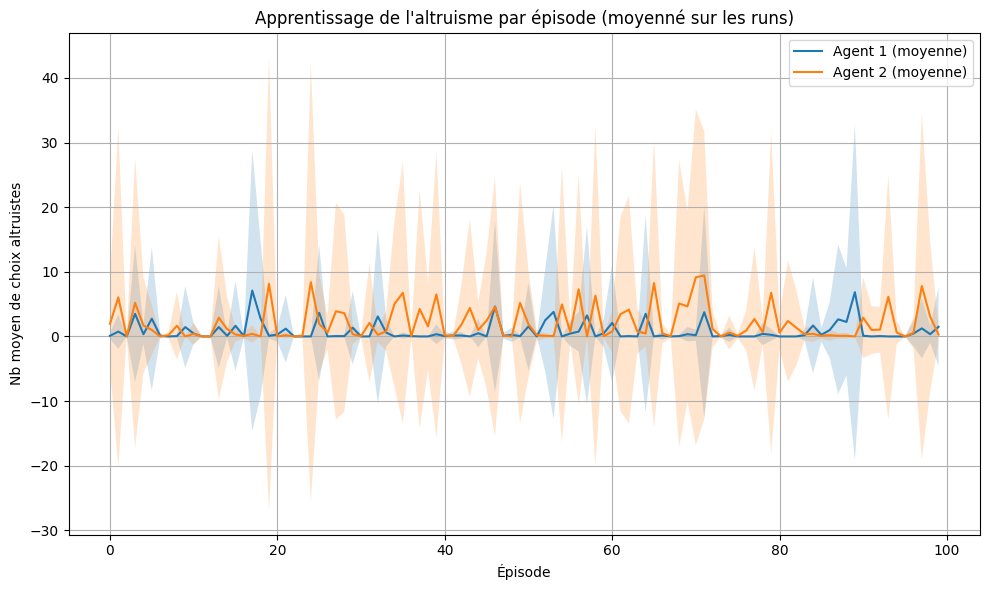

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import random


# --- ENVIRONNEMENT ---
class DenseRewardMaze:
    def __init__(self, size=15, reward_density=0.05):
        self.size = size
        self.nb_states = size * size
        self.nb_actions = 5
        self.reward_density = reward_density
        self._init_transitions()

    def _init_transitions(self):
        self.P = np.zeros((self.nb_states, self.nb_actions, self.nb_states))
        for s in range(self.nb_states):
            row, col = divmod(s, self.size)
            self.P[s, 0, s if row == 0 else s - self.size] = 1
            self.P[s, 1, s if row == self.size - 1 else s + self.size] = 1
            self.P[s, 2, s if col == 0 else s - 1] = 1
            self.P[s, 3, s if col == self.size - 1 else s + 1] = 1
            self.P[s, 4, s] = 1  # exploit (reste sur place)

    def reset(self):
        self.agent_states = [0, self.nb_states - 1]
        self.agent_meals = [0, 0]
        self.rewards = np.zeros(self.nb_states)
        nb_r = int(self.reward_density * self.nb_states)
        free = [s for s in range(self.nb_states) if s not in self.agent_states]
        for s in np.random.choice(free, nb_r, replace=False):
            self.rewards[s] = 1
        return self.agent_states.copy()

    def step(self, actions):
        new_states = []
        for i in range(2):
            s = self.agent_states[i]
            a = actions[i]
            s_next = np.random.choice(self.nb_states, p=self.P[s, a])
            new_states.append(s_next)

        rewards = [0, 0]
        altruistic_skips = [0, 0]

        for i in range(2):
            s = new_states[i]
            other = 1 - i
            if self.rewards[s] > 0:
                if actions[i] == 4:  # exploit
                    if self.agent_meals[i] > self.agent_meals[other]:
                        rewards[i] = 0  # greedy, no gain
                    elif self.agent_meals[i] < self.agent_meals[other]:
                        rewards[i] = 10  # altruist
                        self.rewards[s] = 0
                        self.agent_meals[i] += 1
                    else:
                        rewards[i] = 5  # neutral
                        self.rewards[s] = 0
                        self.agent_meals[i] += 1
                else:
                    if self.agent_meals[i] > self.agent_meals[other]:
                        altruistic_skips[i] += 1

        self.agent_states = new_states
        return new_states.copy(), rewards, altruistic_skips


# --- AGENT Q-LEARNING ---
class AltruistAgent:
    def __init__(self, env, id_, alpha=0.1, gamma=0.95, epsilon=0.2):
        self.env = env
        self.id = id_
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = {}

    def encode_state(self):
        s = self.env.agent_states[self.id]
        has_r = int(self.env.rewards[s] > 0)
        meal_diff = np.clip(self.env.agent_meals[self.id] - self.env.agent_meals[1 - self.id], -2, 2)
        return (s, has_r, meal_diff)

    def get_q(self, state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(5)
        return self.q_table[state]

    def choose_action(self):
        state = self.encode_state()
        q = self.get_q(state)
        if random.random() < self.epsilon:
            return random.randint(0, 4)
        return int(np.argmax(q))

    def learn(self, state, action, reward, next_state):
        q = self.get_q(state)
        next_q = self.get_q(next_state)
        td_target = reward + self.gamma * np.max(next_q)
        q[action] += self.alpha * (td_target - q[action])


# --- ENTRAÎNEMENT PAR RUN ---
def run_single_rl(env, episodes=100, steps_per_ep=30):
    agent1 = AltruistAgent(env, 0)
    agent2 = AltruistAgent(env, 1)
    altruism_log = []

    for ep in range(episodes):
        env.reset()
        count = [0, 0]  # nb de choix altruistes pour agent 1 et 2

        for _ in range(steps_per_ep):
            s1, s2 = agent1.encode_state(), agent2.encode_state()
            a1, a2 = agent1.choose_action(), agent2.choose_action()
            _, rewards, skips = env.step([a1, a2])
            s1n, s2n = agent1.encode_state(), agent2.encode_state()
            agent1.learn(s1, a1, rewards[0], s1n)
            agent2.learn(s2, a2, rewards[1], s2n)
            count[0] += skips[0]
            count[1] += skips[1]

        altruism_log.append(count)

    return np.array(altruism_log)  # shape [episodes, 2]


# --- MULTI-RUN & VISU ---
def multi_run(nb_runs=20, episodes=100, steps_per_ep=30):
    logs = []
    for r in range(nb_runs):
        print(f"Run {r+1}/{nb_runs}")
        env = DenseRewardMaze()
        logs.append(run_single_rl(env, episodes, steps_per_ep))

    logs = np.array(logs)  # [runs, episodes, agents]
    mean = np.mean(logs, axis=0)
    std = np.std(logs, axis=0)

    plt.figure(figsize=(10, 6))
    plt.plot(mean[:, 0], label="Agent 1 (moyenne)")
    plt.plot(mean[:, 1], label="Agent 2 (moyenne)")
    plt.fill_between(np.arange(episodes), mean[:, 0] - std[:, 0], mean[:, 0] + std[:, 0], alpha=0.2)
    plt.fill_between(np.arange(episodes), mean[:, 1] - std[:, 1], mean[:, 1] + std[:, 1], alpha=0.2)
    plt.xlabel("Épisode")
    plt.ylabel("Nb moyen de choix altruistes")
    plt.title("Apprentissage de l'altruisme par épisode (moyenné sur les runs)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    multi_run(nb_runs=20, episodes=100, steps_per_ep=300)
